In [37]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

path='../save_outputs/vol-vfd'
task_cnt = 8

# fsim = f'{path}/hm-sim.f100.n{task_cnt}.r100.log.xlsx'
# fagg = f'{path}/hm-agg.f100.n{task_cnt}.r100.log.xlsx'

fvolsim=f'{path}/prov-vfd-sim-vol.csv'
fvfdsim=f'{path}/prov-vfd-sim-vfd.csv'

fvolsim=f'{path}/prov-vfd-agg-vol.csv'
fvfdsim=f'{path}/prov-vfd-agg-vfd.csv'

In [38]:
# data related methods
def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1000 and i < len(suffixes)-1:
        nbytes /= 1000.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

def check_empty(df,p=True):
    nan_df = df[df.isna().any(axis=1)].copy()
    if not nan_df.empty:
        if p:
            print(f"NaN rows: {nan_df}") # check any nan
        return list(nan_df.index)
    
    null_df = df[df.isnull().any(axis=1)].copy()
    if not null_df.empty:
        if p:
            print(f"NULL rows: {null_df}") # check any null
        return list(null_df.index)
    
def print_list_diff(list1, list2):
    if list1 == list2:
        print("same lists")
    else:
        print("different lists\nindex:\t[list1]\t[list2]")
        for index, (first, second) in enumerate(zip(list1, list2)):
            if first != second:
                # print(index, first, second)
                print(f"{index}:\t{first}]\t[{second}]")

def df_to_csv(df,file_name,suffix=''):
    # df.hash_id=df.hash_id.astype('category').cat.codes
    # out_csv=file_name.replace('prov-vfd-','')
    out_csv=file_name.replace('.csv',f'{suffix}.csv')
    df.to_csv(out_csv,index=False)
    
def read_data(filename, dset=''):
    if '.parquet' in filename:
        df = pd.read_parquet(filename,engine='pyarrow')
    if'.csv' in filename:
        df = pd.read_csv(filename,index_col=False)
    
    if len(dset) > 0:
        df = df[df['dset_name'] == dset]
        
    return df

In [52]:
# networkx related methods
COLOR_MAP = {"task": "#ab2626", # read
            "data_label_vol": "#fc8403", #orange
            "data_label_vfd": "#3879cf", # blue
            "logical_addr": "#69b3d6", #light blue
            "logical_addr_vfd": "#719ed9", # slightly different light lue
            "file": "#154c79", # dark blue
            "read": "#bf7777", # light read
            "write": "#b277bf", #light purpul
            "none": "grey",
            }

def draw_graph(G,color_map=COLOR_MAP, rm_tags=['']):
    pos=nx.get_node_attributes(G,'pos')
    names = nx.get_node_attributes(G,'name')

    node_colors = [] 
    # set node colors
    for name in names.values():
        node_colors.append(color_map[name])
        
    # set node labels
    labels = {}
    for node in names.keys():
        _n = node
        for t in rm_tags:
            _n = str(_n).replace(f"{t}-","")
            _n = str(_n).replace("vol-","")
            _n = str(_n).replace("contact_map","cp")
            _n = str(_n).replace("point_cloud","pc")
            
        if 'addr' in names[node]:
            labels[node] = f'addr : {_n}'
        else:
            labels[node] = _n

    plt.figure(figsize=(25, 10)) #figsize=(40, 10)
    
    bbox = dict(alpha=0.6, fc="black", ec="white", boxstyle="square", color='white') #fc="red", , lw=3
        
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, labels= labels, bbox=bbox, horizontalalignment='left', font_color='white')
    
    for edge in G.edges(data='access_cnt'):
        nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=edge[2], )
    
    plt.axis("off")
    plt.margins(x=0.1)
    plt.show()

def add_attr_dic_edges(G,edges, attr_dict, asize=[]):
    edge_cnt = Counter(edges)
    
    if len(asize) == 0:
        asize = [1] * len(edges)
    
    for i, e in enumerate(edges):
        try:
            attr_dict[e] = {'access_cnt': edge_cnt[e], 'access_size': asize[i]}
        except:
            print(f"i={i} edge={e}")
            # print(asize)
            # traceback.print_exc()
            # break
    
    G.add_edges_from(edges)

def get_graph(in_df, vert_col, source='task', sink='output', tag='', x=0, reverse=False, access_sizes=[]):
    _x = x
    G = nx.DiGraph() #nx.MultiDiGraph()
    
    if '.h' in source:
        G.add_node(source,pos=(_x,0),name="file")
    else:
        G.add_node(source,pos=(_x,0),name="task")
    
    if reverse: vert_col.reverse()
    
    df = pd.DataFrame(columns=vert_col)
    
    for c in vert_col:
        df[c] = f'{tag}-' + in_df[c].astype(str)
    
    sink_edges = []
    source_edges = []
    
    for ic, c in enumerate([vert_col[0], vert_col[-1]]):
        _x +=1
        _y = -1
        # create address position list
        if 'addr' in c:
            org_vals = list(in_df[c])
            _addr_pos = stats.rankdata(org_vals,method='dense')
            
        # for i in range(0,len(vals)):
        for i, v in enumerate(list(df[c])):
            # add node position for each
            if(G.has_node(v) == False):
                _y +=1
                if 'addr' in c:
                    G.add_node(v,pos=(_x,_addr_pos[i]),name=f'{c}')
                else:
                    G.add_node(v,pos=(_x,_y),name=f'{c}')
            
            if c == vert_col[0]: sink_edges.append((source, v))
            else: source_edges.append((v,sink))
    
    attr_dict = {}
    # add source edges and attributes
    add_attr_dic_edges(G,source_edges,attr_dict)
    # add intermediate edges and attributes
    for i in range(1, len(vert_col)):
        two_cols = [vert_col[i-1],vert_col[i]]
        _l1 = df[vert_col[i-1]]
        _l2 = df[vert_col[i]]
        if access_sizes:
            add_attr_dic_edges(G,list(zip(_l1, _l2)),attr_dict,list(in_df[access_sizes[i-1]]))
        else:
            add_attr_dic_edges(G,list(zip(_l1, _l2)),attr_dict)
    # add last attributes
    if access_sizes:
        add_attr_dic_edges(G,sink_edges,attr_dict,list(in_df[access_sizes[-1]]))
    else:
        add_attr_dic_edges(G,sink_edges,attr_dict)

    nx.set_edge_attributes(G, attr_dict)
        
    _x +=1
    if '.h' in sink:
        G.add_node(sink,pos=(_x,0),name="file")
    else:
        G.add_node(sink,pos=(_x,0),name="task")
    
    return G

In [53]:
def merge_df_sim(dfvol, dfvfd):
    df_sim2vol = dfvol[['data_label', 'io_access_idx','dset_name', 'access_size', 'op_type', 'logical_addr']].copy()
    vol_idx2addr_map = dict(zip(df_sim2vol['data_label'], df_sim2vol['logical_addr']))
    
    # df_sim2vol['logical_addr'] = df_sim2vol['logical_addr'].replace(-1,0)
    
    df_sim2vol['logical_addr_map'] = df_sim2vol['logical_addr'].astype(int)

    df_vfd2res = dfvfd[['data_label', 'file_name', 'access_size', 'op_type','start_addr']].copy()
    # df_vol2res.rename(columns={'start_addr':'logical_addr'}, inplace=True)
    df_vfd2res['start_addr'] = df_vfd2res['start_addr'].fillna(0)
    df_vfd2res['logical_addr_map'] = df_vfd2res['start_addr'].astype(int)
    
    # modify all meta mapping address to 0
    df_sim2vol.loc[df_sim2vol['op_type'] == 'meta', 'logical_addr_map'] = 0
    df_vfd2res.loc[df_vfd2res['op_type'] == 'meta', 'logical_addr_map'] = 0
    
    df_vfd2res.rename(columns={'start_addr':'logical_addr_vfd'}, inplace=True)
    df_merged = df_sim2vol.merge(df_vfd2res, how='inner', on=['logical_addr_map'], suffixes=['_vol','_vfd'])

    # populate file_name
    df_merged['file_name'] = df_merged['file_name'].fillna('task0000/residue_100.h5')

    
    
    return df_merged, vol_idx2addr_map

fsim_vol='../save_outputs/vol-vfd/prov-vfd-sim-vol.csv'
fsim_vfd='../save_outputs/vol-vfd/prov-vfd-sim-vfd.csv'

df_sim_vol = read_data(fsim_vol)
df_sim_vfd = read_data(fsim_vfd)

# print(df_sim_vfd['start_addr'])

# # print(df_sim_vol.head(3))
df_merged, vol_idx2addr_map = merge_df_sim(df_sim_vol,df_sim_vfd)

# # print(df_merged.head(10))
# # df_merged.rename(columns={'io_access_idx_vol':'vol_idx', 'logical_addr':'access'}, inplace=True)
print(df_merged.columns)
# print(df_merged.tail(5))
# print(df_merged[df_merged['data_label_vol'].str.contains('meta-point_cloud')]) 

Index(['data_label_vol', 'io_access_idx', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr', 'logical_addr_map', 'data_label_vfd',
       'file_name', 'access_size_vfd', 'op_type_vfd', 'logical_addr_vfd'],
      dtype='object')


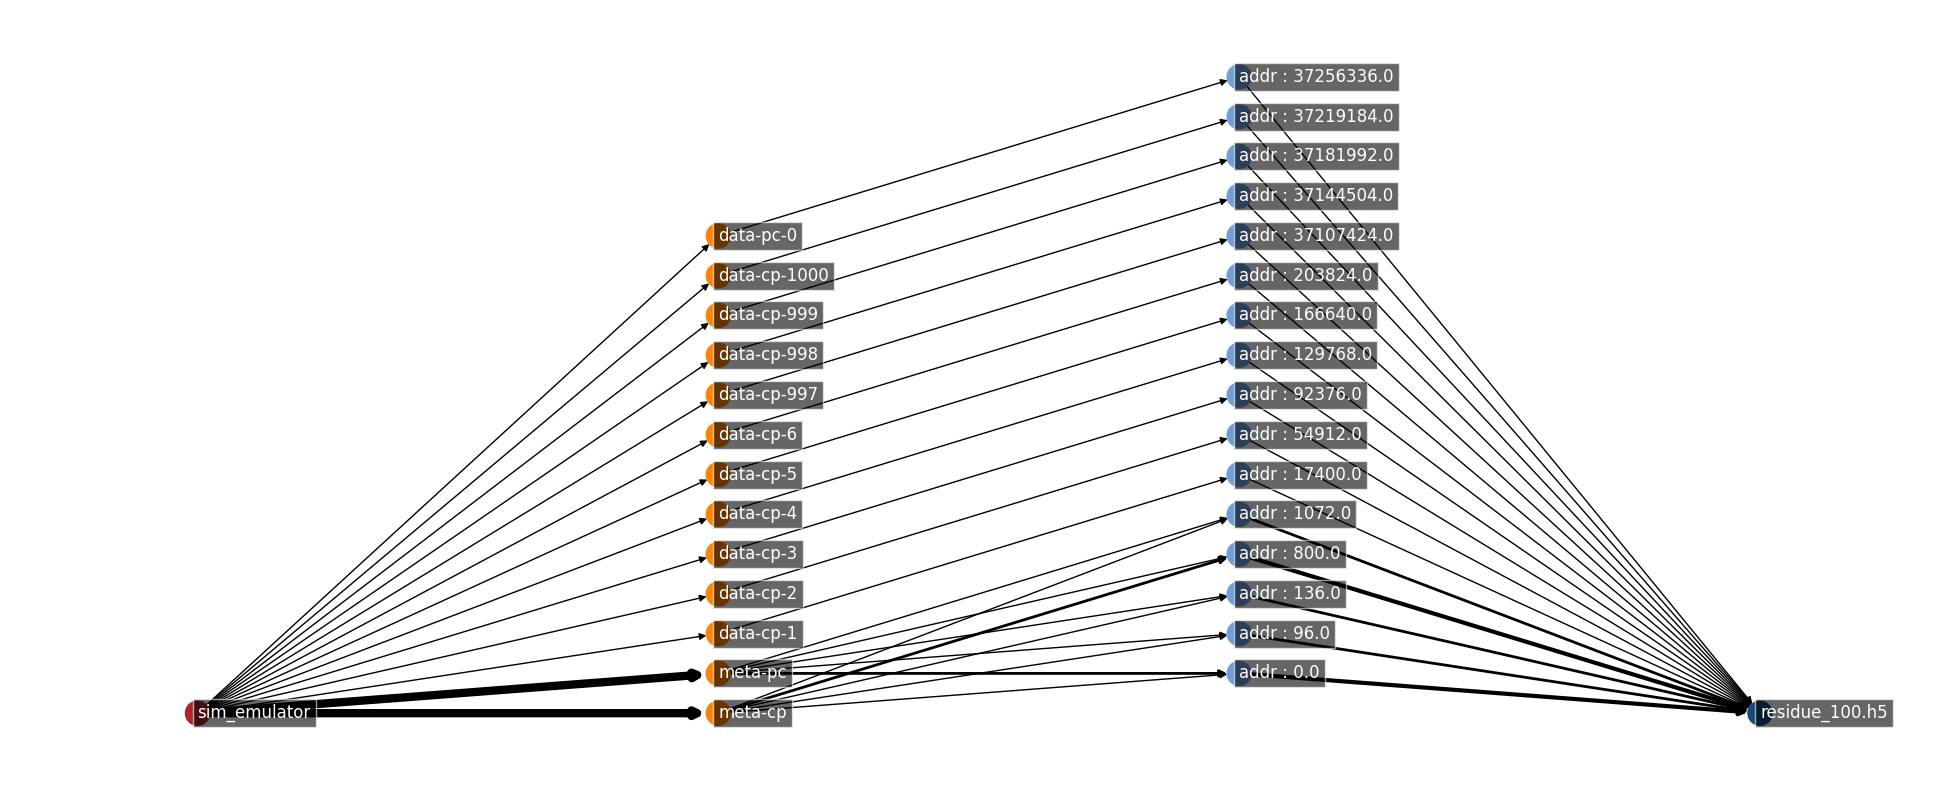

In [67]:
# print(df_merged[df_merged['data_label_vol'].str.match('vol-data-contact_map-1')])

df_show = pd.concat([df_merged.head(6),df_merged.iloc[175:181], df_merged.iloc[443:449],df_merged.tail(5)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr'
G_SIM = get_graph(df_show,['data_label_vol', 'logical_addr_vfd'], 
                  source='sim_emulator', sink='residue_100.h5',tag='sim',
                  access_sizes=['access_size_vol','access_size_vfd'])

# print(pos)
draw_graph(G_SIM,COLOR_MAP,rm_tags=['sim'])

In [55]:
# map only read
def merge_df_agg_read(dfvol, dfvfd,vol_idx2addr_map):
    df_agg2vol = dfvol[['data_label', 'io_access_idx','dset_name', 'access_size', 'op_type','logical_addr']].copy()
    df_vfd2res = dfvfd[['data_label', 'io_access_idx','file_name', 'access_size', 'op_type','next_addr','start_addr']].copy()

    # df_agg2vol['logical_addr'] = df_agg2vol['logical_addr'].astype(int)
    
    # address map for vol
    df_agg2vol['logical_addr_map'] = df_agg2vol['data_label'].map(vol_idx2addr_map)
    df_agg2vol.loc[df_agg2vol['op_type'] == 'meta', 'logical_addr_map'] = 0 # all meta map to 0
    
    # split by op_type
    df_vfd2res_meta = df_vfd2res[df_vfd2res['op_type'] == 'meta'].copy() # use 0 for meta
    df_vfd2res_loc = df_vfd2res[df_vfd2res['op_type'] == 'loc'].copy() # this match vol with start_addr
    df_vfd2res_data = df_vfd2res[df_vfd2res['op_type'] == 'data'].copy() # this match loc with next_addr
    
    # address map for vfd-meta
    df_vfd2res_meta['logical_addr_map'] = 0
    df_vfd2res_loc['logical_addr_map'] = df_vfd2res_loc['start_addr']
    
    # address map for vfd-data
    df_vfd2res_data_map  = dict(zip(df_vfd2res_loc['next_addr'], df_vfd2res_loc['start_addr']))
    df_vfd2res_data['logical_addr_map'] = df_vfd2res_data['start_addr'].map(df_vfd2res_data_map)
    
    nan_idx = check_empty(df_vfd2res_data,p=False)
    for idx in nan_idx:
        df_vfd2res_data.loc[idx, ['logical_addr_map']] = df_vfd2res.iloc[idx]['start_addr']
    
    # # rename and conver types
    # df_vol2res_meta['logical_addr_map'] = df_vol2res_meta['start_addr']
    # df_vol2res_loc['logical_addr_map'] = df_vol2res_loc['start_addr']
    
    df_vfd2res = pd.concat([df_vfd2res_meta,df_vfd2res_loc, df_vfd2res_data], axis=0).set_index('io_access_idx')

    # # df_vol2res_data['logical_addr_map'] = df_vol2res_data['logical_addr_map'].astype(int)
    df_vfd2res.rename(columns={'start_addr':'logical_addr'}, inplace=True)
    df_vfd2res['logical_addr'] = df_vfd2res['logical_addr'].replace(-1,0)
    
    df_merged = df_agg2vol.merge(df_vfd2res, how='inner', on=['logical_addr_map'], suffixes=['_vol','_vfd'])
    
    return df_merged

dfvol='../save_outputs/vol-vfd/prov-vfd-agg-vol-read.csv'
dfvfd='../save_outputs/vol-vfd/prov-vfd-agg-vfd-read.csv'

dfvol = read_data(dfvol)
dfvfd = read_data(dfvfd)

df_agg_read_merged = merge_df_agg_read(dfvol,dfvfd,vol_idx2addr_map)

# print(df_agg_read_merged.head(20))

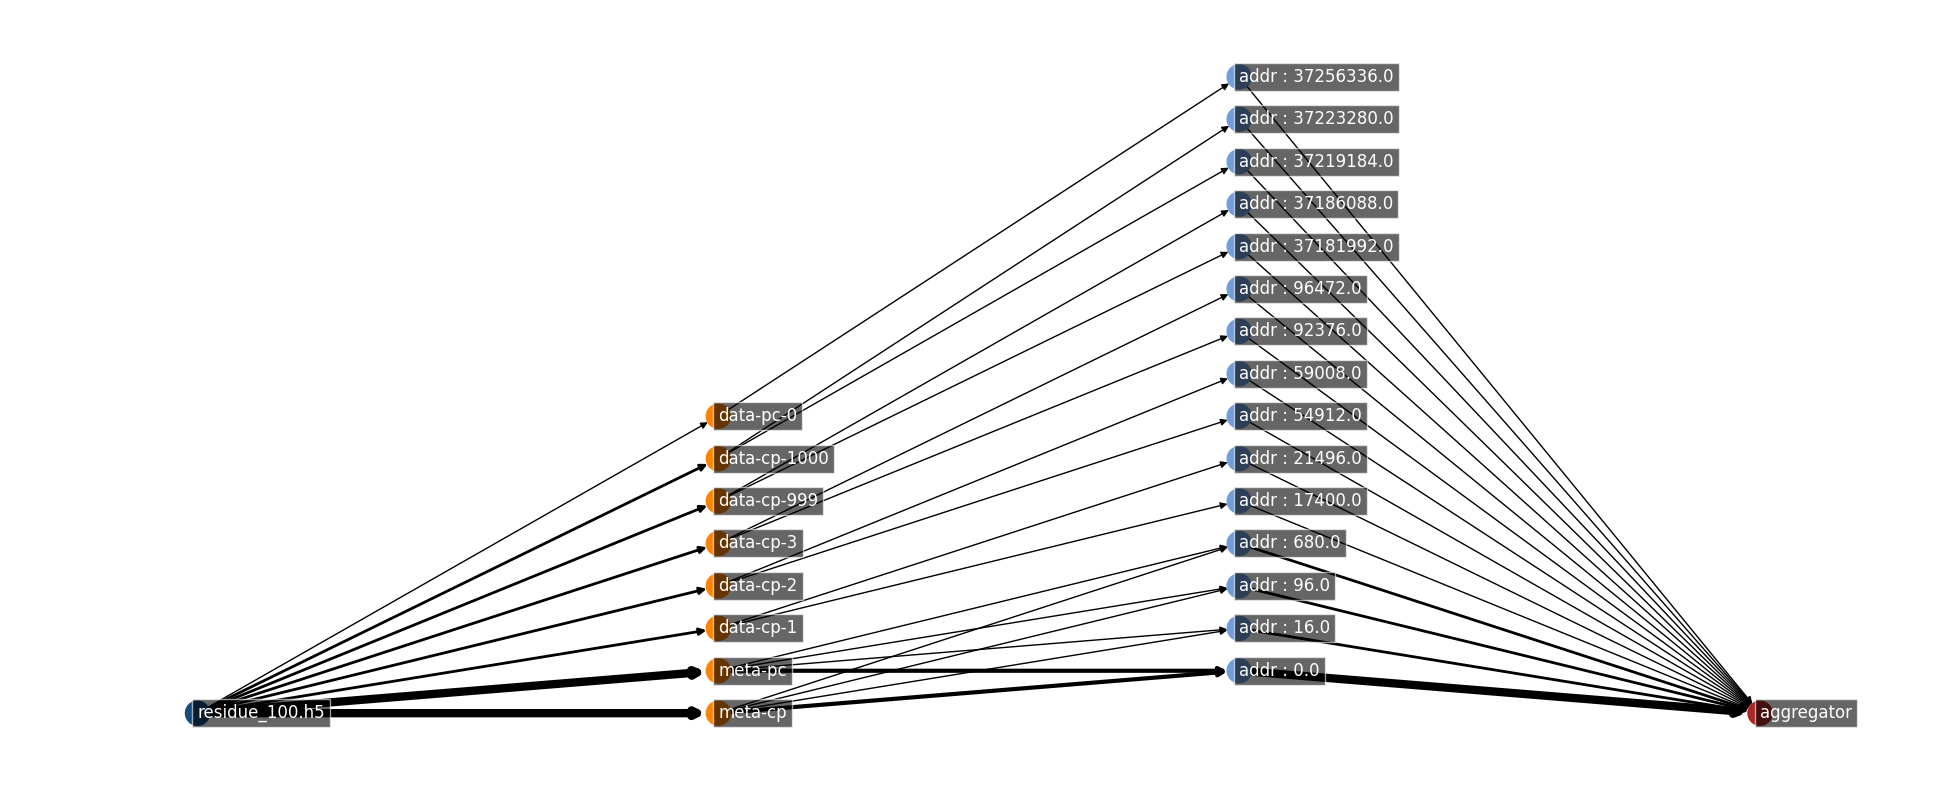

In [64]:
# print(df_agg_read_merged[df_agg_read_merged['data_label_vol'].str.match('vol-data-contact_map-1')])
# print(df_agg_read_merged[df_agg_read_merged['data_label_vol'].str.match('vol-meta-point_cloud')])

df_show = pd.concat([df_agg_read_merged.head(6),df_agg_read_merged.iloc[195:201], df_agg_read_merged.iloc[391:397],df_agg_read_merged.tail(5)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr_vfd'
x_pos = max(nx.get_node_attributes(G_SIM,'pos').values())[0]

G_AGG_R = get_graph(df_show,['logical_addr_vfd', 'data_label_vol'], 
                  source='residue_100.h5', sink='aggregator',
                  tag='agg_r',x=x_pos, reverse=True,
                  access_sizes=['access_size_vfd','access_size_vol'])

# G_AGG_R = get_graph(df_show,['logical_addr_vfd', 'data_label_vol'], source='residue_100.h5', sink='aggregator',tag='agg_r',x=x_pos, reverse=True)
draw_graph(G_AGG_R,COLOR_MAP, rm_tags=['agg_r'])

In [65]:
# map only write
def apply_map(x,df_vfd2res_data):
    newdf = pd.DataFrame()
    if x.name == 'loc':
        df_vfd2res_loc_map  = dict(zip(df_vfd2res_data['data_label'], df_vfd2res_data['start_addr']))
        newdf['loc_map'] = x['data_label'].map(df_vfd2res_loc_map)
    return newdf
        

def merge_df_agg_write(dfvol, dfvfd):
    df_agg2vol = dfvol[['data_label','dset_name', 'access_size','op_type', 'logical_addr']].copy()
    df_vol2vfd = dfvfd[['data_label', 'io_access_idx', 'file_name', 'access_size', 'start_addr', 'next_addr','op_type']].copy()

    # vol map # set 0 for meta
    df_agg2vol['logical_addr_map'] = df_agg2vol['logical_addr'].astype(int)
    df_agg2vol.loc[df_agg2vol['op_type'].str.match('meta'), 'logical_addr_map'] = 0
    
    # data map
    df_vfd2res_data = df_vol2vfd[df_vol2vfd['op_type'] == 'data'].copy()
    df_vfd2res_data['logical_addr_map'] = df_vfd2res_data['start_addr'].astype(int)
    # modify point_cloud to use only 1 address for mapping 
    idx_pc = df_agg2vol.data_label.str.match(f'vol-data-point_cloud-0').idxmax()
    PC_START_ADDR = int(df_agg2vol.iloc[idx_pc]['logical_addr'])
    df_vfd2res_data.loc[df_vfd2res_data['data_label'].str.contains('point_cloud'), 'logical_addr_map'] = PC_START_ADDR
    
    # loc maps by data_label 
    df_vfd2res_loc = df_vol2vfd[df_vol2vfd['op_type'] == 'loc'].copy()
    vfd2res_loc_map  = dict(zip(df_vfd2res_data['data_label'], df_vfd2res_data['start_addr']))
    df_vfd2res_loc['logical_addr_map'] = df_vfd2res_loc['data_label'].map(vfd2res_loc_map)
    
    # lheap maps by address
    df_vfd2res_lheap = df_vol2vfd[df_vol2vfd['op_type'] == 'lheap'].copy()
    vfd2res_lheap_map = dict(zip(df_vfd2res_data['start_addr'], df_vfd2res_data['next_addr']))
    df_vfd2res_lheap['logical_addr_map'] = df_vfd2res_lheap['next_addr'].map(vfd2res_lheap_map)
    
    # meta maps to 0
    df_vfd2res_meta = df_vol2vfd[df_vol2vfd['op_type'] == 'meta'].copy()
    df_vfd2res_meta['logical_addr_map'] = 0
    
    df_vfd2res = pd.concat([df_vfd2res_data,df_vfd2res_loc,df_vfd2res_lheap,df_vfd2res_meta], axis=0) #.set_index('io_access_idx')
    df_vfd2res = df_vfd2res.rename(columns={'start_addr':'logical_addr'})
    df_merged = df_agg2vol.merge(df_vfd2res, how='inner', on=['logical_addr_map'], suffixes=['_vol','_vfd'])

    # populate file_name
    df_merged['file_name'] = df_merged['file_name'].fillna('aggregate.h5')
    
    return df_merged


fagg_vol_write='../save_outputs/vol-vfd/prov-vfd-agg-vol-write.csv'
fagg_vfd_write='../save_outputs/vol-vfd/prov-vfd-agg-vfd-write.csv'
dfvol = read_data(fagg_vol_write)
dfvfd = read_data(fagg_vfd_write)
df_agg_write_merged = merge_df_agg_write(dfvol,dfvfd)

print(df_agg_write_merged.columns)
# print(df_agg_write_merged.head(20))

Index(['data_label_vol', 'dset_name', 'access_size_vol', 'op_type_vol',
       'logical_addr_vol', 'logical_addr_map', 'data_label_vfd',
       'io_access_idx', 'file_name', 'access_size_vfd', 'logical_addr_vfd',
       'next_addr', 'op_type_vfd'],
      dtype='object')


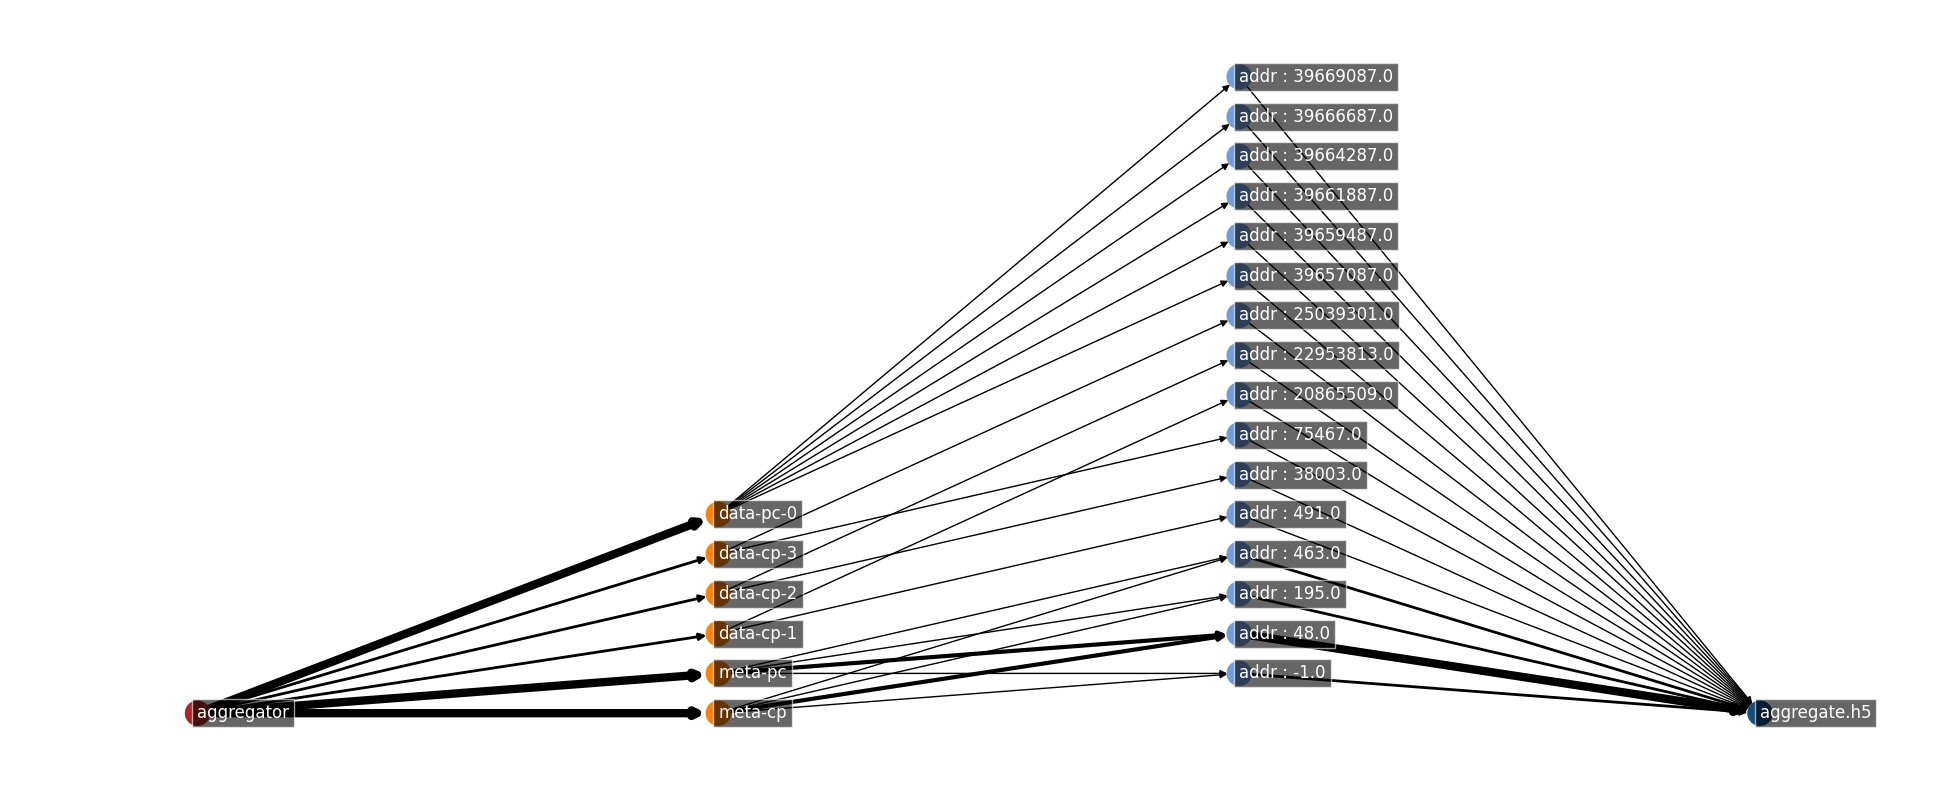

In [66]:
# print(df_agg_write_merged[df_agg_write_merged['data_label_vol'].str.match('vol-data-contact_map-1')])
# print(df_agg_write_merged[df_agg_write_merged['data_label_vol'].str.match('vol-meta-point_cloud')])

df_show = pd.concat([df_agg_write_merged.head(6),df_agg_write_merged.iloc[88:94], df_agg_write_merged.iloc[233:239],df_agg_write_merged.tail(6)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr'
x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0]
G_AGG_W = get_graph(df_show,['data_label_vol', 'logical_addr_vfd'], 
                    source='aggregator', sink='aggregate.h5',
                    tag='agg_w',x=x_pos,
                    access_sizes=['access_size_vol','access_size_vfd'])

draw_graph(G_AGG_W,COLOR_MAP,rm_tags=['agg_w'])

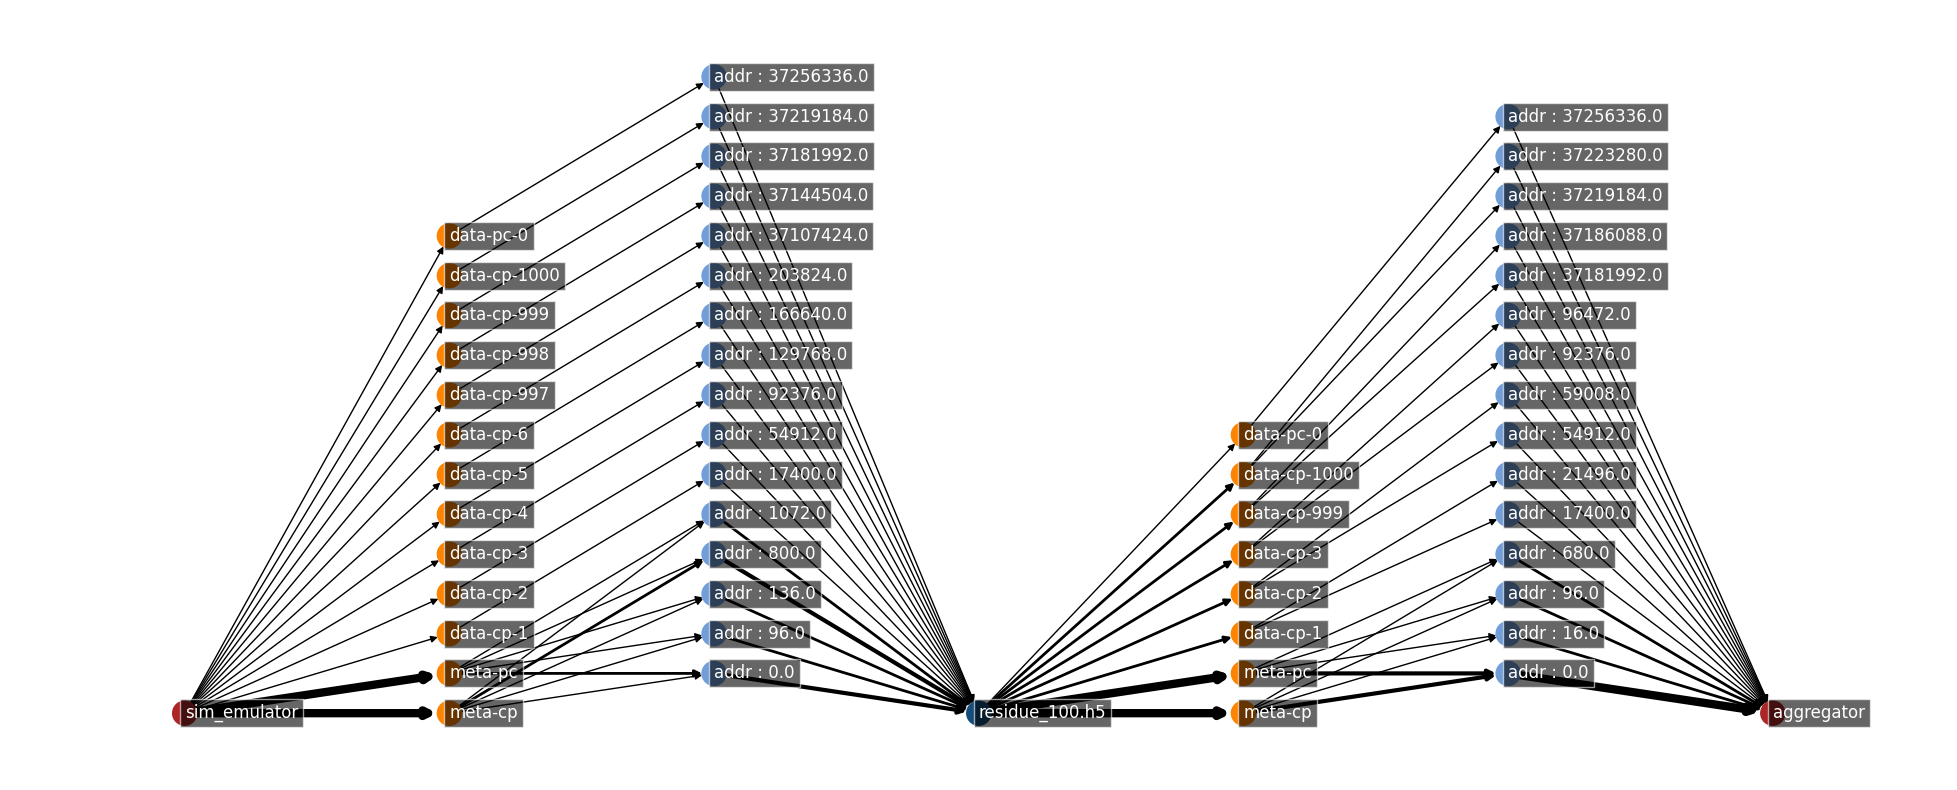

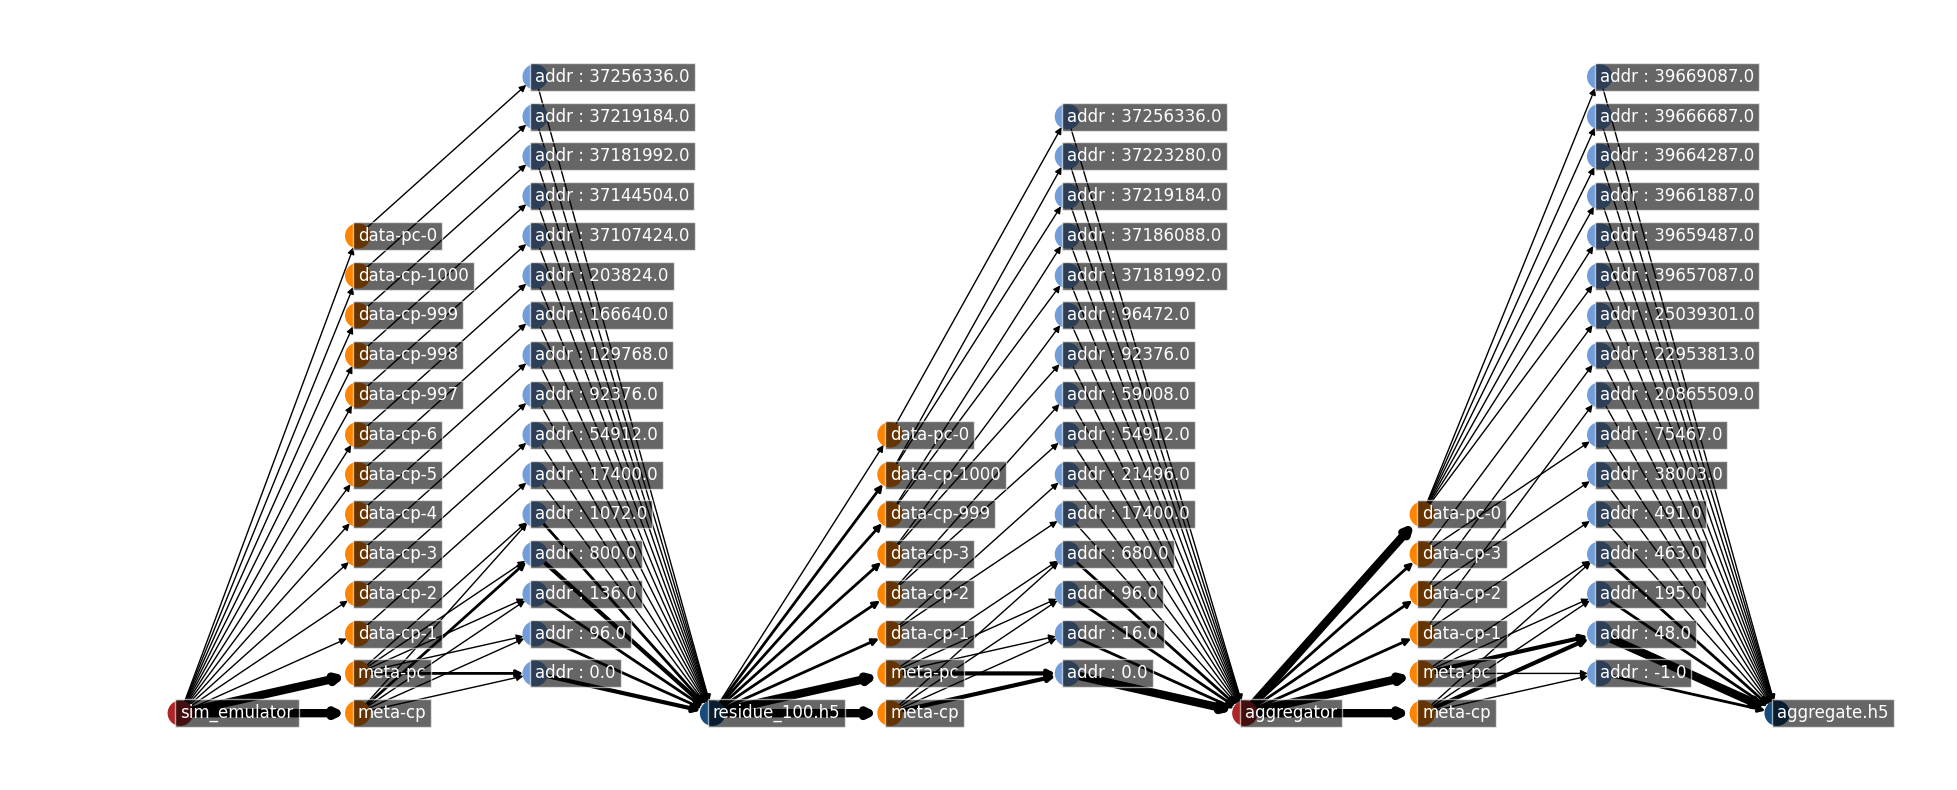

In [68]:
F1 = nx.compose(G_SIM,G_AGG_R)
draw_graph(F1,COLOR_MAP,rm_tags=['sim','agg_r'])

F2 = nx.compose(F1, G_AGG_W)
draw_graph(F2,COLOR_MAP,rm_tags=['sim','agg_r','agg_w'])

In [60]:
# Sankey related codes
def get_nodes_for_sankey(G):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[]}

    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        node_type = attr['name']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        node_dict_for_sankey['label'].append(node_name)
        node_dict_for_sankey['color'].append(COLOR_MAP[node_type])
    return node_dict_for_sankey, node_dict_ref

def get_links_for_sankey(G, node_dict_ref,edge_attr=['access_cnt','access_size'],rm_tags=[]):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[], 'label': []}
    
    attr_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        # print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)
        # link_dict_for_sankey['value'].append(attr['weight])
        
        cnt = attr_cnt[(u,v)]
        size = attr_size[(u,v)]
        link_dict_for_sankey['value'].append(cnt)
        _str = f"{edge_attr[0]} = {cnt}, {edge_attr[1]} = {size}, ave_acc_size={round(size/cnt,2)}"
        link_dict_for_sankey['label'].append(_str)
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [61]:
sim_nodes, sim_nodes_dict = get_nodes_for_sankey(G_SIM)

# print(node_ref2)

sim_links = get_links_for_sankey(G_SIM, sim_nodes_dict)
fig = go.Figure(go.Sankey(
            node = sim_nodes,
            link = sim_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-sim_w-vol-vfd-.html")

In [62]:
f1_nodes, f1_nodes_dict = get_nodes_for_sankey(F1)

# print(node_ref2)

f1_links = get_links_for_sankey(F1, f1_nodes_dict)
fig = go.Figure(go.Sankey(
            node = f1_nodes,
            link = f1_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-sim_w_agg_r-vol-vfd.html")

In [63]:
f2_nodes, f2_nodes_dict = get_nodes_for_sankey(F2)

# print(node_ref2)

f2_links = get_links_for_sankey(F2, f2_nodes_dict)
fig = go.Figure(go.Sankey(
            node = f2_nodes,
            link = f2_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-sim_w_agg_r_w-vol-vfd.html")